In [111]:
import pandas as pd
import numpy as np
from IPython.display import display
import scipy.stats as st
import statsmodels.api as sm
import matplotlib.pyplot as plt

import statsmodels.stats.api as sms
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve as roc_auc
from sklearn.metrics import roc_auc_score
from catboost import CatBoostClassifier, Pool, cv

from sklearn.metrics import auc
from catboost.utils import get_roc_curve


# Оглавление <a id='root'>
* [Задание 1](#1)
    * [Задача 1](#1.1)
    * [Задача 2](#1.2)
* [Задание 2](#2)
    * [Задача 1](#2.1)
    * [Задача 2](#2.2)
    * [Задача 3](#2.3)
    * [Задача 4](#2.4)
* [Задание 3](#3)
    * [Задача 1](#3.1)
* [Задание 4](#4)
    * [Обработка пропусков данных](#4.0)
    * [Задача 1](#4.1)
        * [Модель 1](#4.1.1)
        * [Модель 2](#4.1.2)
        * [Вывод](#4.1.3)

# Задание 1 <a id='1'>

In [2]:
df = pd.read_excel('3_task_моделирование.xlsx', sheet_name ='Задание 1', usecols="A:B", names=['observation','time'])
df.observation=df.observation.astype('int')
df.set_index('observation', inplace=True)
display(df.head())


,time
observation,
1,27.0
2,24.0
3,17.0
4,19.0
5,30.0


## Задача 1 <a id='1.1'>

В соответствии со стандартами обслуживания  клиентов среднее время ожидания клиентом ответа оператора не должно превышать 20 секунд. Для проверки качества обслуживания клиентов была проанализирована выборка из 30 звонков. На основе представленных данных можно ли утверждать, что  среднее время ожидания ответа оператора возросло и составляет более 20 секунд (допуская, что данные в генеральной совокупности имеют нормальное распределение).

посмотрим на инфу о датафрейме

In [3]:
display(df.describe())
display(df.info())
display(df.isna().sum())

,time
count,30.000000
mean,22.833333
std,6.475861
min,7.000000
25%,19.000000
50%,24.000000
75%,27.750000
max,36.000000


<class 'pandas.core.frame.DataFrame'>
Int64Index: 30 entries, 1 to 30
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   time    30 non-null     float64
dtypes: float64(1)
memory usage: 480.0 bytes


None

time    0
dtype: int64

Все супер, пропусков нет, всего есть 30 наблюдений, среднее и медианное значения не совсем совпадают, поэтому вглянем на распределение. Есть ощущение, что не совсем нормальное

<AxesSubplot:ylabel='Count'>

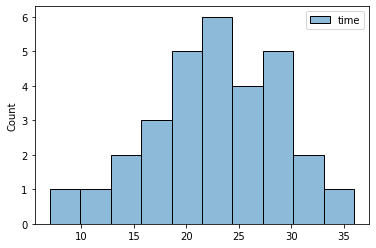

In [4]:
sns.histplot(data = df, bins=10)

Так и есть, не совсем нормальное. Плюс у нас менее 36 наблюдений, поэтому сравнивать будем через t-распределение. Построим 95% доверительный интервал оценки среднего и проверим, попадает ли наш норматив в доверительный интервал оценки среднего.

In [5]:
st.t.interval(0.95, df.shape[0]-1, loc=df.time.mean(), scale=st.sem(df.time))

(20.41520692452492, 25.251459742141744)

In [6]:
st.t.interval(0.99, df.shape[0]-1, loc=df.time.mean(), scale=st.sem(df.time))

(19.57438900296361, 26.092277663703054)

В целом, с ростом числа наблюдений, t-распределение стремится к нормальному, так что данный способ проверки имеет место быть. Мы получили, что доверительный доверительный интервал среднего значения генеральной совокупности больше 20 секунд (в предположении 95% доверительного интервала). Однако, подтвердить факт того, что среднее время "возрасло", в текущей постановке задачи, мы не можем, потому как не знаем какое оно было. Вполне может быть, что стандарт был изначально завышен относительно реальных данных, либо установлен на основании 99% доверительного интервала (в этом случает доверительный интервал шире и нижняя граница меньше 20 секунд).


[К оглавлению](#root)

## Задача 2 <a id='1.2'>

Предположим, что необходимо оценить текущее среднее значение времени ответа оператора с точностью +/- 2 секунды и построить 95% доверительный интервал для этой величины. Определите, требуемый для этого объем выборки.

$n=(\frac{Z \sigma}{e})^2$ где $e$-приемлемая ошибка выборочного исследования $\sigma$-стандартное отклонение генеральной совокупности $Z$- z-значение требуемого доверительного уровня 

В нашем случае $e=2$, $Z=1.96$, а $\sigma=\sqrt{\frac{\sum({x-\hat{x}})^2}{n-1}}$ нужно рассчитать

In [7]:
sigma = df.time.std(ddof=1)
Z = 1.96
e = 2

n = ((Z*sigma)/e)**2
print(f'требуемый объем выборки для исследования: {n:.0f} наблюдений')


требуемый объем выборки для исследования: 40 наблюдений


[К оглавлению](#root)

## Задание 2 <a id='2'>

In [8]:
df = pd.read_excel('3_task_моделирование.xlsx', sheet_name ='Задание 2', usecols="A:B", names=['expenses','sales'])

display(df.head())
display(df.info())
display(df.describe())

,expenses,sales
0,230.1,22.1
1,44.5,10.4
2,17.2,9.3
3,151.5,18.5
4,180.8,12.9


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   expenses  200 non-null    float64
 1   sales     200 non-null    float64
dtypes: float64(2)
memory usage: 3.2 KB


None

,expenses,sales
count,200.000000,200.000000
mean,147.042500,14.022500
std,85.854236,5.217457
min,0.700000,1.600000
25%,74.375000,10.375000
50%,149.750000,12.900000
75%,218.825000,17.400000
max,296.400000,27.000000


### Задача 1 <a id='2.1'>

Постройте линейную регрессионную модель, позволяющую предсказывать объем продаж в регионе в зависимости от расходов на рекламу. Напишите уравнение регресссии.

в первую очередь посмотрим на график зависимости продаж от затрат.

Text(0, 0.5, 'Продажи (тыс. шт)')

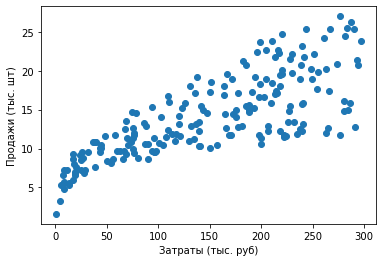

In [9]:
plt.scatter( df.expenses, df.sales)
plt.xlabel('Затраты (тыс. руб)')
plt.ylabel('Продажи (тыс. шт)')

Тут надо вспомнить условия применения линейной регрессии:
- Линейная взаимосвязь переменных
- Нормальность распределения остатков
- Гомоскедастичность 

Вот с гомоскедастичностью и нормальностью распределения остатков, для нашей линейной регрессии - будут проблемы, потому как график у нас представим ввиде факела. Попробуем исправить это. Поскольку график похож на экспоненциальный - логорифмируем и посмотрим на график

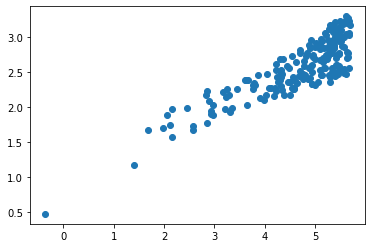

In [10]:
plt.scatter(np.log(df.expenses), np.log(df.sales))


вот так уже лучше. Мы сохранили линейность, при этом приблизились к гомоскедастичности и нормальности распределения (хотя про нормальность - вопрос, скорее всего в результате оно будет скошено). 
Теперь можно попробовать обучить модельку и вывести уравнение регрессии.

In [11]:
target = df.drop(columns=['expenses'])
features = df.drop(columns=['sales'])

X = np.log(features)
y = np.log(target)

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                  sales   R-squared:                       0.742
Model:                            OLS   Adj. R-squared:                  0.741
Method:                 Least Squares   F-statistic:                     569.8
Date:                Sun, 19 Jun 2022   Prob (F-statistic):           3.51e-60
Time:                        20:43:27   Log-Likelihood:                 28.454
No. Observations:                 200   AIC:                            -52.91
Df Residuals:                     198   BIC:                            -46.31
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9052      0.071     12.737      0.0

In [12]:
intercept = est2.params['const']
alpha = est2.params['expenses']

if alpha>=0: 
    sign = '+' 
else:
    sign = ''
print(f'уравнение регрессии имеет вид: log({target.columns[0]})={intercept}{sign}{alpha}*log({features.columns[0]})')

уравнение регрессии имеет вид: log(sales)=0.9052454593989981+0.35503573348588763*log(expenses)


В целом, наша модель не лишена смысла: с ростом количествва затрат на маркетинг - растет количество продаж

Посмотрим на распределение остатоков модели

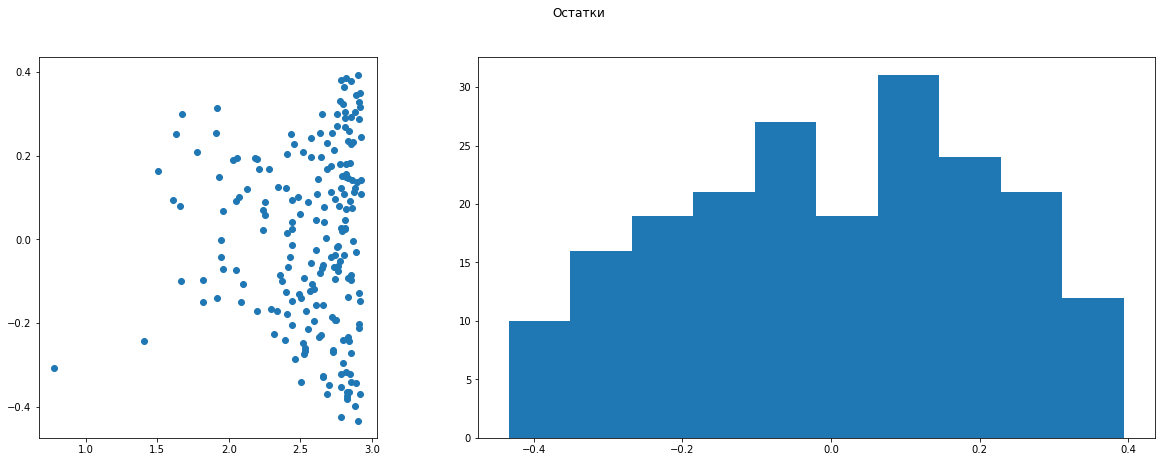

In [13]:
y_pred = intercept+alpha*np.log(features).values
redusals = np.log(target.values)-y_pred


fig, ax = plt.subplots(1,2, figsize=(20,7), gridspec_kw={'width_ratios': [1, 2]})
fig.suptitle('Остатки')
ax[0].scatter(y =redusals, x=y_pred)
ax[1].hist(redusals[:,0])



plt.show()


в целом, не сказать что наши остатки распределены нормально, как и предполагалось присутствует и скошенность. В целом, я бы не рекомендовал использовать такую модель, потому как не выполняется свойство нормальности и гомоскедастичности распределения остатков. Но задание есть задание.

[К оглалению](#root)

### Задача 2 <a id='2.2'>

Дайте графическую интерпритацию, полученных результатов (отобразите на одном графике уравнение регрессии и наблюдения, представленные в наборе данных)

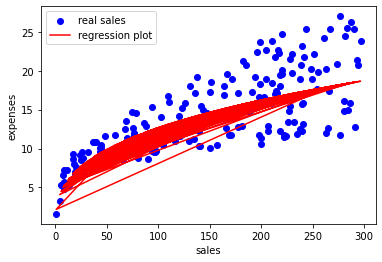

In [14]:
pred = [np.exp(i) for i in y_pred]


data = []
for i in range(0, len(pred)):
    arr = [pred[i],target.values[i][0],features.values[i][0]]
    data.append(arr)

res = pd.DataFrame(data,  columns=['yhat','target','features'])

plt.scatter( res.features, res.target, color='blue', label='real sales')
plt.plot( res.features, res.yhat, color = 'red', label='regression plot')
plt.xlabel('sales')
plt.ylabel('expenses')
plt.legend()
plt.show()


[К оглалению](#root)

### Задача 3 <a id='2.3'>

Предскажите объем продаж при расходах на рекламу в 121 тыс. руб.

Поскольку мы обучали модель на логорифмированных данных, то и для предсказаний, вместо того, чтобы передавать 121 тысячу, мы передадим логарифм от 121 тысячи (обучались мы на данных, где затраты в тысячах. Т.е. вместо 121 000 предаем просто 121), а само предсказание не забудем перевести в обратную сторону.

In [15]:
spendings = 121
expected_sales = np.exp(intercept+alpha*np.log(spendings))

print(f'при затратах в {spendings} тысячу на маркетинг, модель прогнозирует {expected_sales:.2f} тысяч едениц продаж')

при затратах в 121 тысячу на маркетинг, модель прогнозирует 13.57 тысяч едениц продаж


[К оглалению](#root)

### Задача 4 <a id='2.4'>

Сделайте вывод о статистической значимости коэффициентов линейной регрессии.

In [16]:
if est2.pvalues[1]<0.05:
    msg = f'''
    На основании того факта, что согласно t-тесту, для коэффициента при независимой переменной мы получили оценку p-value меньше 0.05 (у нас она ~{est2.pvalues[1]:.2f}) 
    мы можем отклонить нулевую гипотезу о том, что у нас отсутсвует линейный тренд в данных, а значит наша модель нашла взаимосвязи между зависимой и независимой переменными. 
    И все это значит, что взаимосвязь между переменными - статистически значима (на 95% уровне значимости).
    '''
else:
    msg =f'''
    К сожалению, построенная нами модель не смогла найти статистически значимую (на 95% уровне значимости) взаимосвязь между переменными.
    '''

print(f'''
Полученная модель объясняет {est2.rsquared_adj:.2%} вариации зависимой перменной
Это не много и не мало. Скорее всего, что логично, наша модель не учитывает другие значимые факторы. Например это может быть работа колл-центра.
'''+msg)


Полученная модель объясняет 74.08% вариации зависимой перменной
Это не много и не мало. Скорее всего, что логично, наша модель не учитывает другие значимые факторы. Например это может быть работа колл-центра.

    На основании того факта, что согласно t-тесту, для коэффициента при независимой переменной мы получили оценку p-value меньше 0.05 (у нас она ~0.00) 
    мы можем отклонить нулевую гипотезу о том, что у нас отсутсвует линейный тренд в данных, а значит наша модель нашла взаимосвязи между зависимой и независимой переменными. 
    И все это значит, что взаимосвязь между переменными - статистически значима (на 95% уровне значимости).
    


[К оглалению](#root)

## Задание 3 <a id='3'>

Имеются две модели, предсказывающие вероятность дефолта клиента и фактические наблюдения данного события (1 - факт дефолта клиента, 0 - отсутствие  дефолта клиента)

In [17]:
df = pd.read_excel('3_task_моделирование.xlsx', sheet_name ='Задание 3', usecols="A:C", names=['real','model_1','model_2'])

display(df.head())
display(df.info())


,real,model_1,model_2
0,0.0,0.409821,0.526825
1,0.0,0.576899,0.606770
2,0.0,0.470889,0.499478
3,0.0,0.256406,0.334723
4,0.0,0.324825,0.403021


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 311 entries, 0 to 310
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   real     311 non-null    float64
 1   model_1  311 non-null    float64
 2   model_2  311 non-null    float64
dtypes: float64(3)
memory usage: 7.4 KB


None

### Задача 1 <a id='3.1'>

Предложите метрику качества, позволяющую сравнить эти модели и выбрать наилучшую на основе представленных данных.  Также желательно предоставить графическую интерпретацию полученных результатов

Посмотрим на баланс классов

In [18]:
not_defolt = df[df.real==0].shape[0]
defolt = df.shape[0]-not_defolt
print(f'всего клиентов без дефолта: {not_defolt} \n всего клиентов с дефолтом: {defolt}')

всего клиентов без дефолта: 157 
 всего клиентов с дефолтом: 154


Отлично, дисбаланса классов у нас не наблюдается, значит можно как минимум использовать метрику accuracy. Но есть одно "но" - модели прогнозируют не четкие метки класса, а вероятность отнести того или иного клиента к одному из двух классов. Вполне понятно почему это сделано - чтобы можно было более сегментировать тех, у кого возможен дефолт. В условиях, когда ресурсы ограничены (а количество специалистов всегда конечно) - целесообразно в первую очередь работать с теми клиентами, риск дефолта у которых выше, а значит, нужно как-то более детально сегментировать клиентов. 

Так или иначе - accuracy нам не очень подходит (как в прочем метрики полноты, точности и их комбинацию - метрика f1) просто потому, что мы не можем их расчитать, когда у нас целевая переменная бинарна, а предсказания - непрерывны. Даже, если нам это удастся рассчитать эти метрики, например мы зададим какой-то порог отнесения к классу (threshhold), все равно остается риск, что при повторном обучении (например после поступления новых данных ввиду резкого изменения внешней ситуации а-ля "а что произошло?" в марте 2022г.), в обучающую выборку могут попасть исключительно объекты одного из классов. В этом случае расчитать precision ($\frac{TP}{TP+FP}$) может быть проблематично (положительные объекты ведь отстутствуют), а нам, все же, хочется, чтобы наша система хорошо работала и таких условиях.

Итого, что мы имеем:
- мы хотим, чтобы наша метрика работала даже на несбалансированных данных
- мы хотим не быть привязанными к threshold (т.е. к конкретному порогу начиная с которого мы помечаем объект, как относящийся к классу)

В целом, под эти требования подходи AUC-ROC ( площадь под кривой в координатах ($FPR=\frac{FP}{N}$ ; $TPR=\frac{TP}{P}$ ))



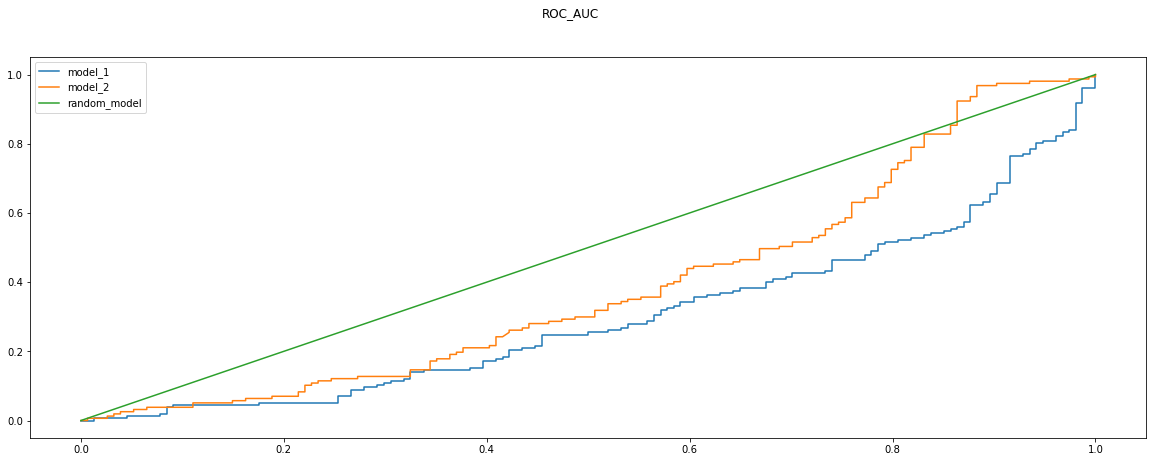

In [19]:

fpr_1, tpr_1, thresholds_1 = roc_auc(df.real, df.model_1)

fpr_2, tpr_2, thresholds_2 = roc_auc(df.real, df.model_2)


fig, ax = plt.subplots(figsize=(20,7))
fig.suptitle('ROC_AUC')
ax.plot(tpr_1, fpr_1, label='model_1')
ax.plot(tpr_2, fpr_2, label='model_2')
ax.plot([[0],[1]],[[0],[1]], label='random_model')
plt.legend()
plt.show()


[К оглалению](#root)

## Задание 4 <a id='4'>

Данные:	
Предложенная таблица содержит данные по 5000 клиентов:	
- num - Порядковый номер клиента
- predictor1-5 - Переменные (предикторы) по которым необходимо построить модель. Все переменные являются количественными.
- target - Целевая бинарная переменная, обозначающая факт дефолта клиента


N.B.: predictor 3 содержит пропущенные значения, выбор метода их обработки остается за соискателем.	

In [20]:
df = pd.read_excel('3_task_моделирование.xlsx', sheet_name ='Задание 4', usecols="A:g", names=['num','predictor_1','predictor_2','predictor_3','predictor_4','predictor_5','target'])

display(df.head())
display(df.info())
display(df.isna().sum())

,num,predictor_1,predictor_2,predictor_3,predictor_4,predictor_5,target
0,1.0,12423.0,710.0,441.5,5.0,4631.0,1.0
1,2.0,13983.0,1106.0,NaN,3.0,4256.0,1.0
2,3.0,15520.0,1276.0,391.5,1.0,4397.0,0.0
3,4.0,29535.0,1106.0,NaN,1.0,3772.0,1.0
4,5.0,26154.0,976.0,315.0,5.0,2445.0,1.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   num          10000 non-null  float64
 1   predictor_1  10000 non-null  float64
 2   predictor_2  10000 non-null  float64
 3   predictor_3  8087 non-null   float64
 4   predictor_4  10000 non-null  float64
 5   predictor_5  10000 non-null  float64
 6   target       10000 non-null  float64
dtypes: float64(7)
memory usage: 547.0 KB


None

num               0
predictor_1       0
predictor_2       0
predictor_3    1913
predictor_4       0
predictor_5       0
target            0
dtype: int64

Обработаем пропуски <a id='4.0'></a>. 
Для этого у нас есть четыре основных пути:
- востановить пропуски на основании зависимостей с другими данными;
- заполнить средним или медианным значением;
- пометить как пропущенные и отпустить ситуацию;
- удалить колонки с пропущенными значениями;
- удалить строки с пропущенными значениями.


Пятый путь нам не по-карману, удалить 20% датасета - действие сомнительной адекватности. Поэтому, попробуем по порядку первые 2 метода и, если ничего толкового не получится - применим третий или четвертый (если нет корреляции с зависимой переменной - можно и удалить столбец).

Первый метод подразумевает востановление данных на основе регрессии, и позволяет получать правдоподобное заполнение пропусков. Но тут есть проблема, а именно: реальные данные зачастую подразумевают некоторый разброс значений, а в этом мметоде мы лишаемся этой вариативности, и, как следствие, корреляция между "востанавливаемым" и остальными признаками искусственно усиливается. С ростом вариации значений признака пропуски которого мы заполняем, и/или процента пропущенных строк - метод становится все хуже и хуже для конечного результата. 

Мы выяснили, что у нас есть 20% пропусков. Посмотрим, может быть вариативность признака не такая большая.

In [21]:
df.predictor_3.unique()

array([441.5,   nan, 391.5, 315. , 377. , 380. , 397. , 416. , 277.5,
       384.5, 445.5, 364.5, 330.5, 169. , 325. , 401. , 403.5, 300.5,
       419. , 304. , 422. , 303.5, 380.5, 307.5, 383. , 385. , 359. ,
       347.5, 336. , 401.5, 376.5, 328. , 417. , 216.5, 377.5, 422.5,
       379.5, 304.5, 406. , 371. , 424.5, 277. , 362.5, 224.5, 357. ,
       382. , 400.5, 255. , 316. , 281.5, 400. , 326.5, 116.5, 434. ,
       309.5, 447. , 333.5, 444. , 353. , 465. , 409. , 452.5, 338.5,
       217.5, 385.5, 394.5, 309. , 339. , 310. , 432. , 449. , 473. ,
       404. , 473.5, 432.5, 261.5, 464. , 418.5, 297.5, 317.5, 451. ,
       355.5, 475.5, 343.5, 357.5, 479. , 375.5, 417.5, 438. , 368.5,
       476. , 423. , 426. , 271. , 442. , 430. , 427. , 232.5, 351. ,
       352.5, 433. , 434.5, 430.5, 406.5, 219. , 288.5, 469.5, 199.5,
       374. , 265.5, 425. , 293.5, 344. , 462.5, 372. , 248. , 350.5,
       464.5, 233. , 291.5, 462. , 398.5, 360. , 497.5, 485.5, 425.5,
       327. , 367. ,

Мда, вариативность признака большая, процент пропущенных значений большой - нужно пробовать другой методы. Посмотрим на среднее и медианное значения

In [22]:
df.predictor_3.describe()

count    8087.000000
mean      368.662174
std        68.536786
min        62.000000
25%       325.000000
50%       377.500000
75%       419.000000
max       512.500000
Name: predictor_3, dtype: float64

В целом, у нас близко среднее и медианные значения. Но чем заполнять? Судя по всему - у нас скошенный влево (медиана больше среднего значения). Посмотрим как изменится наше распределение если мы заменим средним или медианой, потому как при использовании этого метода можно лекго, без регистраций и смс, изменить все показатели характеризующие распределение, за исключением того, которым заменяем пропуски.

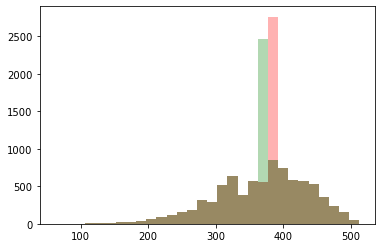

,real,median,mean
count,8087.000000,10000.00000,10000.000000
mean,368.662174,370.35285,368.662174
std,68.536786,61.73082,61.632859
min,62.000000,62.00000,62.000000
25%,325.000000,332.50000,332.500000
50%,377.500000,377.50000,368.662174
75%,419.000000,407.50000,407.500000
max,512.500000,512.50000,512.500000


In [23]:
plt.hist(df[~df.predictor_3.isna()].predictor_3, bins=30,color='black', alpha=0.2)
plt.hist(df.predictor_3.fillna(df[~df.predictor_3.isna()].predictor_3.median()), bins=30, color='red', alpha=0.3)
plt.hist(df.predictor_3.fillna(df[~df.predictor_3.isna()].predictor_3.mean()), bins=30, color='green', alpha=0.3)
plt.show()

pd.DataFrame(pd.DataFrame(df[~df.predictor_3.isna()].predictor_3.describe()).rename(columns={'predictor_3':'real'})).join(
pd.DataFrame(df.predictor_3.fillna(df[~df.predictor_3.isna()].predictor_3.median()).describe()).rename(columns={'predictor_3':'median'}).join(
    pd.DataFrame(df.predictor_3.fillna(df[~df.predictor_3.isna()].predictor_3.mean()).describe()).rename(columns={'predictor_3':'mean'}))
)

Вот и ответ. Будем заполнять медианным значением, потому что с случае заполнения средним мы выравниваем наше распределение и среднее начинает почти совпадать с медианой, а нам бы хотелось минимально изменить распределение.

In [24]:
df.predictor_3.fillna(df[~df.predictor_3.isna()].predictor_3.median(), inplace=True)
df.predictor_3.isna().sum()

0

[К оглавлению](#root)

### Задача 1 <a id='4.1'>

Необходимо построить модель, позволяющую предсказывать вероятность дефолта клиента. Предлагается построить 2 конкурирующие модели (например, логистическая регрессия и дерево решений) и произвести выбор наилучшей модели на основе показателя качества AUC ROC (площадь под ROC-кривой).

Необходимо описание (не более 3 страниц) логики построения моделей. Также желательно представить графическую интерпретацию результатов.

При построении моделей разрешается использовать любой статистический пакет\платформу, которым вы владеете.

Взглянем на данные

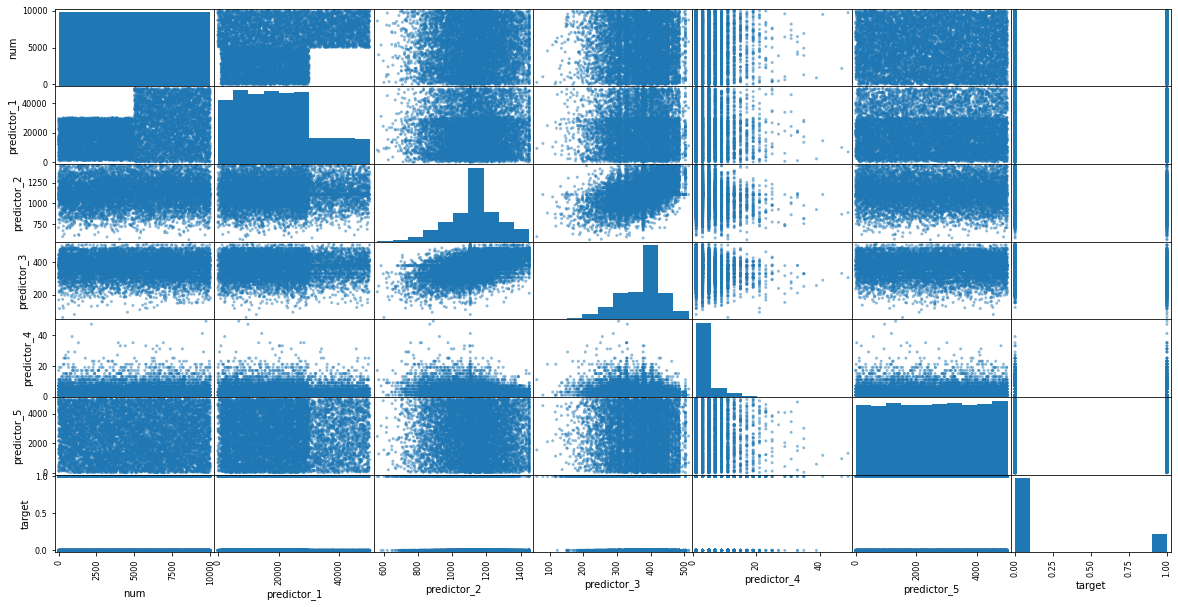

In [25]:
pd.plotting.scatter_matrix(df, figsize=(20,10))
plt.show()

Отлично, сразу, с ходу, у нас дисбаланс классов, а значит - метрика AUC-ROC тут прямо в тему.
И, судя по всему, есть корреляция между вторым и третим предиктором. Построим матрицу корреляций и проверим

In [26]:
# удалим колонку с номером наблюдений, потому что она не несет никакого признака
df.drop(columns='num', inplace=True)
df.corr()

,predictor_1,predictor_2,predictor_3,predictor_4,predictor_5,target
predictor_1,1.000000,0.024318,-0.000536,-0.012252,0.002024,-0.007787
predictor_2,0.024318,1.000000,0.422611,-0.255252,-0.028135,-0.261663
predictor_3,-0.000536,0.422611,1.000000,-0.243960,-0.009769,-0.275649
predictor_4,-0.012252,-0.255252,-0.243960,1.000000,-0.014792,0.213800
predictor_5,0.002024,-0.028135,-0.009769,-0.014792,1.000000,0.006806
target,-0.007787,-0.261663,-0.275649,0.213800,0.006806,1.000000


Интересный результат: predictor_2 действительно сильновато коррелирует с predictor_3, а вот, что более интересно - predictor_1 и perdictor_5 - очень слабо коррелируют с таргетом. В целом, можно их попробовать удалить из признаков и тем самым облегчить сложность модели, а значит и повысить точность.

,predictor_2,predictor_3,predictor_4,target
predictor_2,1.000000,0.422611,-0.255252,-0.261663
predictor_3,0.422611,1.000000,-0.243960,-0.275649
predictor_4,-0.255252,-0.243960,1.000000,0.213800
target,-0.261663,-0.275649,0.213800,1.000000


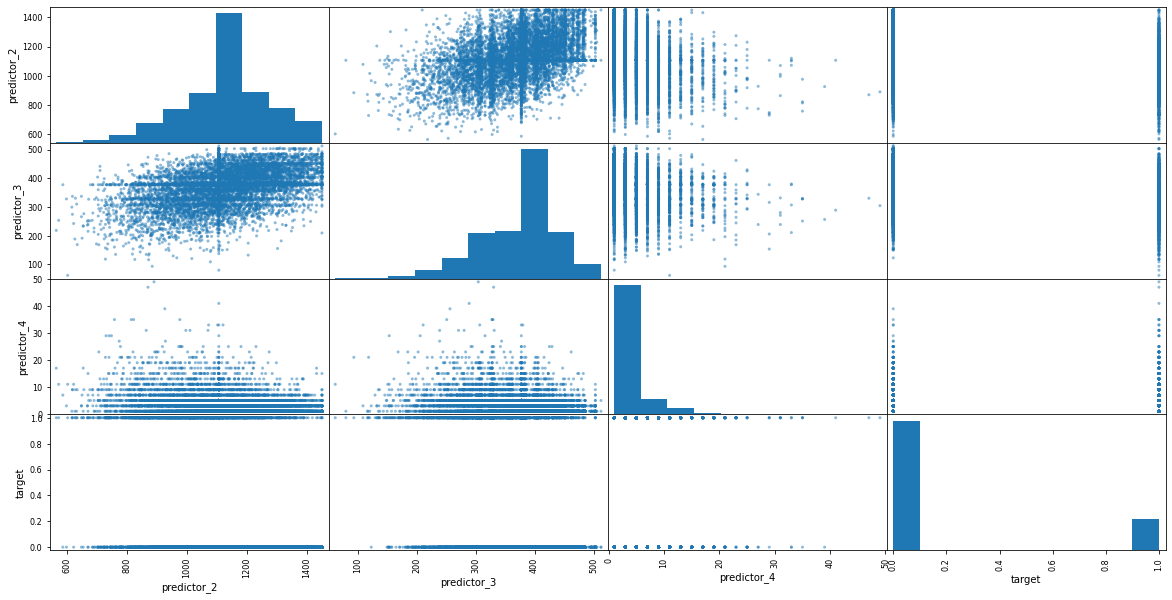

In [27]:
new_df = df.drop(columns=['predictor_1','predictor_5']).copy()
display(new_df.corr())
pd.plotting.scatter_matrix(new_df, figsize=(20,10))
plt.show()

теперь глаза разбегаются меньше и заметно, что predictor_4  у нас, по своей сути - категориальная переменная, а значит - ее нужно закодировать. Для этого у нас в распоряжении есть минимум 2 метода: LableEncoding и OHE. Первый применяется когда данные упорядочены (например 0-начальная школа, 1-средняя школа, 2-среднее специальное образование и тд) и есть много категорий, а второй - когда данные не упорядочены (например 0-Японимя, 1-Россия, 2-Франция и тд) и данных не много. Мы не знаем, какие именно данные лежат в основе predictor_4, поэтому, если их немного - будем пологать, что это не упорядоченные данные.


In [28]:
len(df.predictor_4.unique())

22

Будем использовать технику OHE. У нас нет задачи, чтобы наша модель была легко интерпретируемой, равно как нам не нужно повторять процедуру кодирования (мы сначала кодируем, а уже потом делим на тренировочную и тестовую выборки), поэтому OHE можно делать просто через get_dummies(), а не через OneHotEncoder() из sklearn.

In [29]:
new_df.join(
            pd.get_dummies(df.predictor_4, drop_first=True)
        ).drop(columns='predictor_4', inplace=True)

Теперь поделим на тестовую и валидационные выборки

In [30]:
target = new_df.target.copy()
features = new_df.drop(columns='target').copy()

print(features.shape, target.shape)

features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.2)
print(features_train.shape, target_train.shape)
print(features_test.shape, target_test.shape)

(10000, 3) (10000,)
(8000, 3) (8000,)
(2000, 3) (2000,)


а еще - было бы неплохо стандартизовать переменные. Они у нас разного масштаба.

In [79]:
scalar = StandardScaler()
scalar.fit(features_train)

features_train_scaler = scalar.transform(features_train)
features_test_scaler = scalar.transform(features_test)


[К оглавлению](#root)

#### Модель 1 <a id= '4.1.1'>

Ну и попробуем обучить модель градиентного бустинга над деревьями, с помощью библиотеки catboost. Для поиска оптимальных параметров, сначала пройдемся широкими шагами random search'ом, а затем более мелкими через grid search. Естественно обучаться будем через кросс-валидацию (ее сделаем на 5 фолдах), а метрикой качества будет площадь под кривой ROC.

In [81]:
cv_dataset = Pool(data=features_train_scaler,
                  label=target_train,
                  cat_features=None)





model_catboost = CatBoostClassifier(loss_function='Logloss', eval_metric='AUC', random_seed=12345)

grid = {'max_depth':range(1,20,1),
        'learning_rate':np.arange(0.1,1,0.1),
        'iterations':range(1,20,1)
       }

random_search_result = model_catboost.randomized_search(grid, 
                                       X=cv_dataset,
                                       cv=5,
                                       plot=False)

depth_catboost = random_search_result['params']['depth']
iterations_catboost = random_search_result['params']['iterations']
learning_rate_catboost = random_search_result['params']['learning_rate']


print(depth_catboost, iterations_catboost, learning_rate_catboost)

0:	test: 0.6270651	best: 0.6270651 (0)	total: 2.51ms	remaining: 5.03ms
1:	test: 0.6767288	best: 0.6767288 (1)	total: 8.27ms	remaining: 4.13ms
2:	test: 0.6998362	best: 0.6998362 (2)	total: 13.6ms	remaining: 0us

bestTest = 0.6998362228
bestIteration = 2

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
0:	loss: 0.6998362	best: 0.6998362 (0)	total: 19.3ms	remaining: 174ms
0:	test: 0.6270651	best: 0.6270651 (0)	total: 3.93ms	remaining: 11.8ms
1:	test: 0.6775681	best: 0.6775681 (1)	total: 11.6ms	remaining: 11.6ms
2:	test: 0.7077368	best: 0.7077368 (2)	total: 14ms	remaining: 4.68ms
3:	test: 0.7099639	best: 0.7099639 (3)	total: 18.3ms	remaining: 0us

bestTest = 0.7099638772
bestIteration = 3

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
1:	loss: 0.7099639	best: 0.7099639 (1)	total: 39.4ms	remaining: 157ms
0:	test: 0.6270

In [82]:

model_catboost = CatBoostClassifier(loss_function='Logloss', eval_metric='AUC', random_seed=12345)

grid = {'max_depth':[14],
        'learning_rate':np.arange(0.1,0.3, 1e-6),
        'iterations':[13]
       }

random_search_result = model_catboost.randomized_search(grid, 
                                       X=cv_dataset,
                                       cv=5,
                                       plot=False)

depth_catboost = random_search_result['params']['depth']
learning_rate_catboost = random_search_result['params']['learning_rate']
iterations_catboost = random_search_result['params']['iterations']


print(depth_catboost, learning_rate_catboost, iterations_catboost)


0:	test: 0.6270651	best: 0.6270651 (0)	total: 1.39ms	remaining: 16.7ms
1:	test: 0.6773245	best: 0.6773245 (1)	total: 4.02ms	remaining: 22.1ms
2:	test: 0.7060518	best: 0.7060518 (2)	total: 8.23ms	remaining: 27.5ms
3:	test: 0.7032304	best: 0.7060518 (2)	total: 9.84ms	remaining: 22.1ms
4:	test: 0.7096526	best: 0.7096526 (4)	total: 29.7ms	remaining: 47.5ms
5:	test: 0.7100646	best: 0.7100646 (5)	total: 33.1ms	remaining: 38.6ms
6:	test: 0.7113631	best: 0.7113631 (6)	total: 80.4ms	remaining: 68.9ms
7:	test: 0.7120366	best: 0.7120366 (7)	total: 84.5ms	remaining: 52.8ms
8:	test: 0.7119371	best: 0.7120366 (7)	total: 132ms	remaining: 58.7ms
9:	test: 0.7147956	best: 0.7147956 (9)	total: 181ms	remaining: 54.4ms
10:	test: 0.7139282	best: 0.7147956 (9)	total: 232ms	remaining: 42.2ms
11:	test: 0.7146183	best: 0.7147956 (9)	total: 243ms	remaining: 20.2ms
12:	test: 0.7149627	best: 0.7149627 (12)	total: 296ms	remaining: 0us

bestTest = 0.7149626527
bestIteration = 12

Metric AUC is not calculated on trai

In [83]:
from catboost.utils import get_roc_curve
import sklearn
from sklearn import metrics

model_catboost = CatBoostClassifier(loss_function='Logloss', 
                                    eval_metric='AUC', 
                                    random_seed=12345,
                                    iterations= iterations_catboost,
                                    depth= depth_catboost,
                                    learning_rate= learning_rate_catboost
                                    )


model_catboost.fit(
    features_train_scaler,target_train,
    cat_features=None,
    verbose=False
)


eval_pool = Pool(features_test_scaler, target_test, cat_features=None)
curve = get_roc_curve(model_catboost, eval_pool)
(fpr, tpr, thresholds)=curve
roc_auc=auc(fpr, tpr)

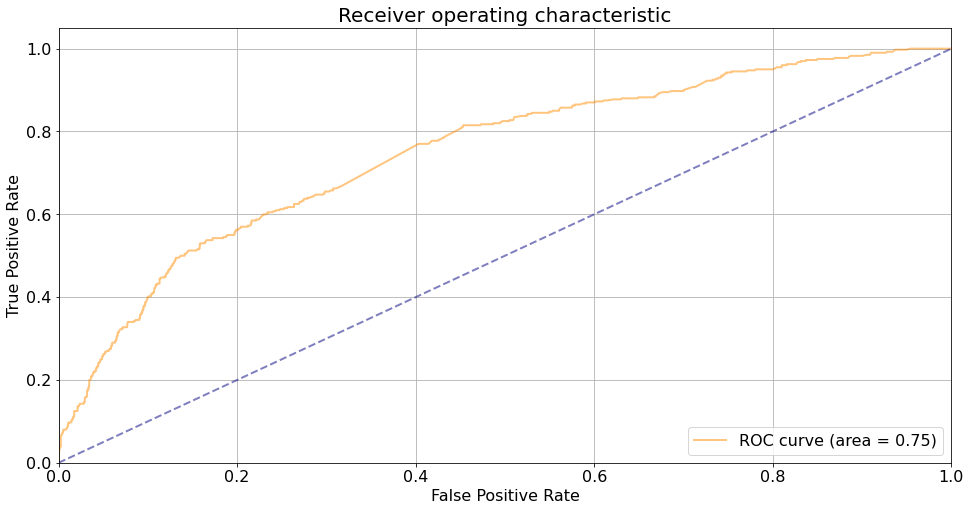

In [84]:
plt.figure(figsize=(16, 8))
lw=2

plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc, alpha=0.5)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', alpha=0.5)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('Receiver operating characteristic', fontsize=20)
plt.legend(loc="lower right", fontsize=16)
plt.show()

[К оглавлению](#root)

#### Модель 2 <a id='4.1.2'>

ну а теперь построим что-нибудь попроще, например логистическую регрессию. Поскольку время уже поджимает - возьмем ее из <a href='https://github.com/goshabaturin/Data_Science_and_Analysis/blob/master/Yandex.Praktikum/2%20-%20%D0%92%D0%B2%D0%B5%D0%B4%D0%B5%D0%BD%D0%B8%D0%B5%20%D0%B2%20%D0%BC%D0%B0%D1%88%D0%B8%D0%BD%D0%BD%D0%BE%D0%B5%20%D0%BE%D0%B1%D1%83%D1%87%D0%B5%D0%BD%D0%B8%D0%B5/2.2%20%D0%9F%D1%80%D0%BE%D0%B3%D0%BD%D0%BE%D0%B7%20%D0%BE%D1%82%D1%82%D0%BE%D0%BA%D0%B0%20%D0%BA%D0%BB%D0%B8%D0%B5%D0%BD%D1%82%D0%BE%D0%B2%20%D0%B8%D0%B7%20%D0%B1%D0%B0%D0%BD%D0%BA%D0%B0/%D0%9F%D1%80%D0%BE%D0%B3%D0%BD%D0%BE%D0%B7%20%D0%BE%D1%82%D1%82%D0%BE%D0%BA%D0%B0%20%D0%BA%D0%BB%D0%B8%D0%B5%D0%BD%D1%82%D0%BE%D0%B2%20%D0%B8%D0%B7%20%D0%B1%D0%B0%D0%BD%D0%BA%D0%B0.ipynb'>вот этого своего же материала </a> (там как раз тоже дисбаланс классов).

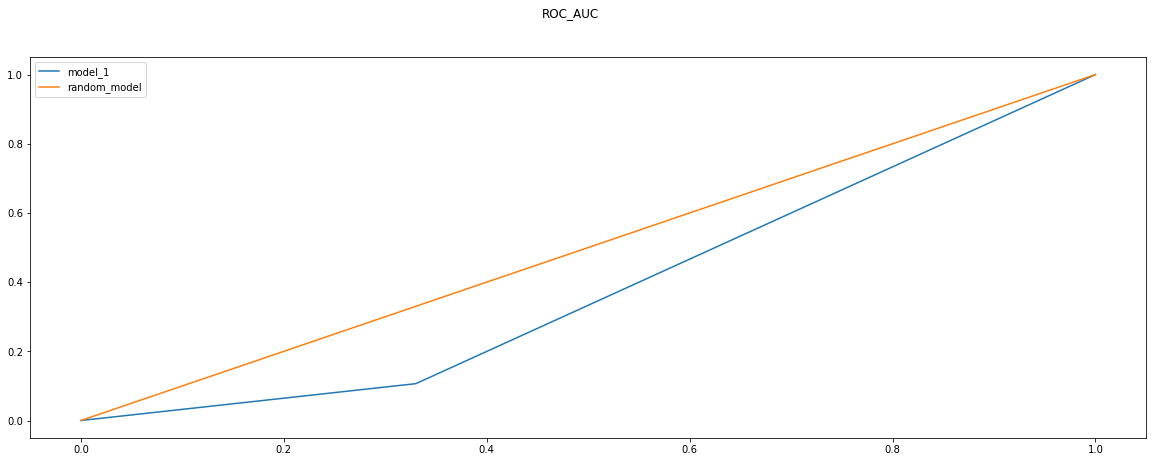

In [121]:

def upsample(features, target, repeat):
    #разделим выборку на отрицательные и положительные объекты
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    
    # скопируем несколько раз положительные объекты
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    # перемешаем строки, так чтоб у нас не было несколько одинаковых блоков, но так чтоб были одинаковые строки
    # по сути, если представить в виде строк, то мы перемешиваем строки таблицы, но не трогаем столбцы
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled




features_train_scaler_upsampled, target_train_scaler_upsampled = upsample(pd.DataFrame(features_train_scaler), target_train.reset_index(drop=True), 5)


model_logistic = LogisticRegressionCV(cv = 5, random_state = 12345 )


model_logistic.fit(features_train_scaler_upsampled,target_train_scaler_upsampled)
predictions_test = model_logistic.predict(features_test_scaler)

res = pd.DataFrame(predictions_test).rename(columns={0:'pred'}).join(target_test.reset_index(drop=True))

fpr_1, tpr_1, thresholds_1 = roc_auc(res.pred, res.target)

fig, ax = plt.subplots(figsize=(20,7))
fig.suptitle('ROC_AUC')
ax.plot(tpr_1, fpr_1, label='model_1')
ax.plot([[0],[1]],[[0],[1]], label='random_model')
plt.legend()
plt.show()

[К оглавлению](#root)

#### Вывод <a id='4.1.3'>

Сравнивая 2 модели по метрике ROC-AUC можно сделать вывод, что модель построенная с помощью бустинга над случайным лесом - гораздо лучше предсказывает вероятность дефолта. Модель построенная с помощью логистической регрессии - работает даже хуже, чем случайное предсказание.

[К оглавлению](#root)